Dataset: E-Commerce Shipping Data from Kaggle: https://www.kaggle.com/prachi13/customer-analytics

## The goal of this EDA notebook is to

1. Fit a classification model to the shipping data to predict late shipments

2. Pickle this model for use in a Plotly-Dash application

3. Get initial intuitions about which features are most important in predicting late shipments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report
from sklearn.inspection import permutation_importance

import pickle

ID: ID Number of Customers.

• Warehouse block: The Company has a big Warehouse which is divided into blocks A,B,C,D,E.

• Mode of shipment: The Company ships the products in multiple ways such as Ship, Flight and Road.

• Customer care calls: The number of calls made from enquiry for enquiry of the shipment.

• Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).

• Cost of the product: Cost of the Product in US Dollars.

• Prior purchases: The Number of Prior Purchase.

• Product importance: The company has categorized the product in the various parameter such as low, medium, high.

• Gender: Male and Female.

• Discount offered: Discount offered on that specific product.

• Weight in gms: It is the weight in grams.

• Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 
indicates it has reached on time.

# Wrangle Data

In [2]:
def wrangle(filepath):
    
    # Load data
    df = pd.read_csv(filepath, index_col="ID")
    
    # Switch binary values in target variable (1 - Yes, 0 - No)
    mask = df["Reached.on.Time_Y.N"] == 1
    df.loc[mask, "Reached_on_time"] = 0
    df.loc[~mask, "Reached_on_time"] = 1
    
    # Drop redundant columns
    df.drop(columns=["Reached.on.Time_Y.N"], inplace=True)
    
    return df

In [3]:
df = wrangle("../data/shipping_data.csv")

In [4]:
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time
ID,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,0.0
2,F,Flight,4,5,216,2,low,M,59,3088,0.0
3,A,Flight,2,2,183,4,low,M,48,3374,0.0
4,B,Flight,3,3,176,4,medium,M,10,1177,0.0
5,C,Flight,2,2,184,3,medium,F,46,2484,0.0


In [5]:
df.shape

(10999, 11)

In [6]:
# Check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10999 entries, 1 to 10999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Warehouse_block      10999 non-null  object 
 1   Mode_of_Shipment     10999 non-null  object 
 2   Customer_care_calls  10999 non-null  int64  
 3   Customer_rating      10999 non-null  int64  
 4   Cost_of_the_Product  10999 non-null  int64  
 5   Prior_purchases      10999 non-null  int64  
 6   Product_importance   10999 non-null  object 
 7   Gender               10999 non-null  object 
 8   Discount_offered     10999 non-null  int64  
 9   Weight_in_gms        10999 non-null  int64  
 10  Reached_on_time      10999 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 1.0+ MB


In [7]:
# Load cleaned data into CSV for Tableau usage
df.to_csv(r"../data/cleaned_data.csv")

# Split Data

In [8]:
X = df.drop(columns="Reached_on_time")
y = df["Reached_on_time"]

In [9]:
# Split X & y into training and testing data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Establish Baseline

In [10]:
# (59.67% of shipments do not reach their destination on time)
baseline_accuracy = y.value_counts(normalize=True).max()
baseline_accuracy

0.5966906082371125

# Statistical Modeling

In [11]:
# Fit OLS model to test statistical significance of features

In [12]:
X_cols = list(X.columns)

def fit_ols():
    # Encode categorical features with 0s and 1s (get_dummies)
    X_ols = pd.get_dummies(X[X_cols])
    
    # Ensure a model returns centered R^2
    X_ols = sm.add_constant(X_ols)
    
    # Instantiate OLS model and fit to data
    model = sm.OLS(y, X_ols).fit()
    
    print(model.summary())

In [13]:
fit_ols()

                            OLS Regression Results                            
Dep. Variable:        Reached_on_time   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     164.1
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        14:55:59   Log-Likelihood:                -6661.2
No. Observations:               10999   AIC:                         1.335e+04
Df Residuals:                   10983   BIC:                         1.347e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

We see that after the first fit of the OLS model, there is only one feature that is not statistically significant (If we consider our signifcance level to be 95%), which is `Customer_rating`

### Stepwise Regression

In [14]:
# We want to drop features that aren't statistically significant and fit the OLS model again
X_cols.remove('Customer_rating')
fit_ols()

                            OLS Regression Results                            
Dep. Variable:        Reached_on_time   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     175.6
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        14:55:59   Log-Likelihood:                -6662.7
No. Observations:               10999   AIC:                         1.336e+04
Df Residuals:                   10984   BIC:                         1.347e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Few Takeaways: 

• `Customer_rating` is the only feature that does not have a statistically significant linear relationship to `Reached_on_time`. Other note: wouldn't it be interesting to predict `Customer_rating` instead? Shouldn't `Customer_rating` come after the order has been delivered if we're thinking chronologically?

• `Warehouse_block_A` has a statistically significant linear relationship to `Reached_on_time`, but the rest of the warehouse blocks do not

• `Mode_of_Shipment_Flight` is not statistically significant, whereas `Mode_of_Shipment_Road` and `Mode_of_Shipment_Ship` are statistically significant

# Randomized Split

In [15]:
# Based on OLS modeling, we'll drop `Customer_rating` as a feature
X_drop_rating = df.drop(columns=["Reached_on_time", "Customer_rating"])

In [16]:
# Split X & y into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_drop_rating, y, test_size=0.2, random_state=42)

# Build Model

In [17]:
# Logistic Regression
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Warehouse_block', 'Mode_of_Shipment',
                                     'Product_importance', 'Gender'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [18]:
# Random Forest Classifier
model_rfc = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

model_rfc.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Warehouse_block', 'Mode_of_Shipment',
                                      'Product_importance', 'Gender'],
                                mapping=[{'col': 'Warehouse_block',
                                          'data_type': dtype('O'),
                                          'mapping': F      1
A      2
D      3
C      4
B      5
NaN   -2
dtype: int64},
                                         {'col': 'Mode_of_Shipment',
                                          'data_type': dtype('O'),
                                          'mapping': Ship      1
Flight    2
Road      3
NaN      -2
dtype: int64},
                                         {'col': 'Product_importance',
                                          'data_type': dtype('O'),
                                          'mapping': low       1
medium    2
high      3
NaN      -2
dtype: int64},
                                         {'col': 'Gend

In [19]:
# Gradient Boosting Classifier
model_gbc = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    GradientBoostingClassifier(random_state=42)
)

model_gbc.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Warehouse_block', 'Mode_of_Shipment',
                                      'Product_importance', 'Gender'],
                                mapping=[{'col': 'Warehouse_block',
                                          'data_type': dtype('O'),
                                          'mapping': F      1
A      2
D      3
C      4
B      5
NaN   -2
dtype: int64},
                                         {'col': 'Mode_of_Shipment',
                                          'data_type': dtype('O'),
                                          'mapping': Ship      1
Flight    2
Road      3
NaN      -2
dtype: int64},
                                         {'col': 'Product_importance',
                                          'data_type': dtype('O'),
                                          'mapping': low       1
medium    2
high      3
NaN      -2
dtype: int64},
                                         {'col': 'Gend

# Check Metrics

In [20]:
# Out of the box score
print("Logistic Regression Accuracy (Train): ", model_lr.score(X_train, y_train))
print("Logistic Regression Accuracy (Test): ", model_lr.score(X_test, y_test))

Logistic Regression Accuracy (Train):  0.6397317877031481
Logistic Regression Accuracy (Test):  0.6427272727272727


In [21]:
# Out of the box score
print("Random Forest Accuracy (Train): ", model_rfc.score(X_train, y_train))
print("Random Forest Accuracy (Test): ", model_rfc.score(X_test, y_test))

Random Forest Accuracy (Train):  1.0
Random Forest Accuracy (Test):  0.6595454545454545


In [22]:
# Out of the box score
print("Gradient Boosting Accuracy (Train): ", model_gbc.score(X_train, y_train))
print("Gradient Boosting Accuracy (Test): ", model_gbc.score(X_test, y_test))

Gradient Boosting Accuracy (Train):  0.7132628707807706
Gradient Boosting Accuracy (Test):  0.6854545454545454


# Tune Parameters

In [23]:
# List of hyperparameters to tune
param_grid = {
    "gradientboostingclassifier__loss": ["deviance", "exponential"],
    "gradientboostingclassifier__n_estimators": [100, 200, 300],
    "gradientboostingclassifier__criterion": ["friedman_mse", "mse"],
    "gradientboostingclassifier__max_depth": [3, 5, 8, 10]
}

### GridSearchCV

In [24]:
# GridSearchCV

model_gbc_gs = GridSearchCV(model_gbc,
                            param_grid=param_grid,
                            n_jobs=-1,
                            cv=3,
                            verbose=5)

model_gbc_gs.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: F

/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: F

/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: F

/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: F

/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/andrewlee/.local/share/virtualenvs/shipping-dashboard-0qStpExL/lib/python3.9/site-packages/category_encoders/utils.py:21: F

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['Warehouse_block',
                                                             'Mode_of_Shipment',
                                                             'Product_importance',
                                                             'Gender'],
                                                       mapping=[{'col': 'Warehouse_block',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': F      1
A      2
D      3
C      4
B      5
NaN   -2
dtype: int64},
                                                                {'col': 'Mode_of_Shipment',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': Ship      1
Flight    2

In [25]:
model_gbc_gs.best_params_

{'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__loss': 'exponential',
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 100}

In [26]:
best_model_gs = model_gbc_gs.best_estimator_

### Scores before Tuning

In [27]:
print("Gradient Boosting Accuracy (Train): ", model_gbc.score(X_train, y_train))
print("Gradient Boosting Accuracy (Test): ", model_gbc.score(X_test, y_test))

Gradient Boosting Accuracy (Train):  0.7132628707807706
Gradient Boosting Accuracy (Test):  0.6854545454545454


### Scores after GridSearchCV

In [28]:
print("Gradient Boosting Accuracy (Train): ", best_model_gs.score(X_train, y_train))
print("Gradient Boosting Accuracy (Test): ", best_model_gs.score(X_test, y_test))

Gradient Boosting Accuracy (Train):  0.7115581316058643
Gradient Boosting Accuracy (Test):  0.685


# Communicate Results

### Confusion Matrix


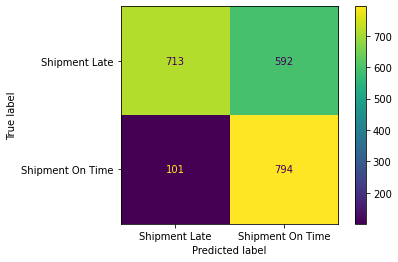

In [29]:
plot_confusion_matrix(best_model_gs, X_test, y_test, values_format=".0f",
                      display_labels=["Shipment Late", "Shipment On Time"])

### Classification Report

In [30]:
print(classification_report(y_test, best_model_gs.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.88      0.55      0.67      1305
         1.0       0.57      0.89      0.70       895

    accuracy                           0.69      2200
   macro avg       0.72      0.72      0.68      2200
weighted avg       0.75      0.69      0.68      2200



### F1 Score


In [31]:
f1_score(y_test, best_model_gs.predict(X_test))

0.6961858833844805

### Permutation Importance

<AxesSubplot:>

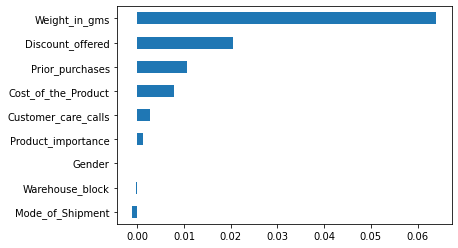

In [32]:
perm_imp = permutation_importance(best_model_gs, X_test, y_test, n_repeats=10,
                                  n_jobs=-1, random_state=42)

data = {"imp_mean": perm_imp["importances_mean"],
        "imp_std": perm_imp["importances_std"]}

df_perm = pd.DataFrame(data, index=X_test.columns).sort_values("imp_mean")

df_perm["imp_mean"].tail(10).plot(kind="barh")

## Export Clean Data / Pickle Model

In [33]:
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time
ID,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,0.0
2,F,Flight,4,5,216,2,low,M,59,3088,0.0
3,A,Flight,2,2,183,4,low,M,48,3374,0.0
4,B,Flight,3,3,176,4,medium,M,10,1177,0.0
5,C,Flight,2,2,184,3,medium,F,46,2484,0.0


In [34]:
# Load cleaned data into CSV for Plotly-Dash usage (shipping.py)
df.drop(columns='Customer_rating', inplace=True)
df.to_csv(r"../data/dash_ready_data.csv")

In [35]:
filename = "../model/gbc.pk1"
pickle.dump(model_gbc, open(filename, 'wb'))